

# Módulo 4 - Big Data
Tarea
Estudiante: Jairo Prado

# Lectura y limpieza

In [1]:
# Cargar el conjunto de datos completo
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType, DoubleType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

diabetes_df = spark \
    .read \
    .format("csv") \
    .option("path", "diabetes_dataset.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("age", IntegerType()),
                StructField("gender", StringType()),
                StructField("ethnicity", StringType()),
                StructField("education_level", StringType()),
                StructField("income_level", StringType()),
                StructField("employment_status", StringType()),
                StructField("smoking_status", StringType()),
                StructField("alcohol_consumption_per_week",  IntegerType()),
                StructField("physical_activity_minutes_per_week", IntegerType()),
                StructField("diet_score", DoubleType()),
                StructField("sleep_hours_per_day", DoubleType()),
                StructField("screen_time_hours_per_day", DoubleType()),
                StructField("family_history_diabetes", IntegerType()),
                StructField("hypertension_history", IntegerType()),
                StructField("cardiovascular_history", IntegerType()),
                StructField("bmi", DoubleType()),
                StructField("waist_to_hip_ratio", DoubleType()),
                StructField("systolic_bp", IntegerType()),
                StructField("diastolic_bp", IntegerType()),
                StructField("heart_rate", IntegerType()),
                StructField("cholesterol_total", IntegerType()),
                StructField("hdl_cholesterol", IntegerType()),
                StructField("ldl_cholesterol", IntegerType()),
                StructField("triglycerides", IntegerType()),
                StructField("glucose_fasting", IntegerType()),
                StructField("glucose_postprandial", IntegerType()),
                StructField("insulin_level", DoubleType()),
                StructField("hba1c", DoubleType()),
                StructField("diabetes_risk_score", DoubleType()),
                StructField("diabetes_stage", StringType()),
                StructField("diagnosed_diabetes", IntegerType())])) \
    .load()

#diabetes_df.printSchema()
diabetes_df.show()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 00:09:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)
25/10/26 00:09:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+---------+---------------+------------+-----------------+--------------+----------------------------+----------------------------------+----------+-------------------+-------------------------+-----------------------+--------------------+----------------------+----+------------------+-----------+------------+----------+-----------------+---------------+---------------+-------------+---------------+--------------------+-------------+-----+-------------------+--------------+------------------+
|age|gender|ethnicity|education_level|income_level|employment_status|smoking_status|alcohol_consumption_per_week|physical_activity_minutes_per_week|diet_score|sleep_hours_per_day|screen_time_hours_per_day|family_history_diabetes|hypertension_history|cardiovascular_history| bmi|waist_to_hip_ratio|systolic_bp|diastolic_bp|heart_rate|cholesterol_total|hdl_cholesterol|ldl_cholesterol|triglycerides|glucose_fasting|glucose_postprandial|insulin_level|hba1c|diabetes_risk_score|diabetes_stage|di

In [2]:
# Seleccionar un subconjunto de las columnas de interés y el objectivo que es el precio
columns_kept = ['age','gender','ethnicity','education_level','income_level','employment_status','smoking_status','alcohol_consumption_per_week','physical_activity_minutes_per_week','diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes','hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c']

target = ['diagnosed_diabetes']

selected_columns_df = diabetes_df.select(columns_kept)

selected_columns_df.show()

+---+------+---------+---------------+------------+-----------------+--------------+----------------------------+----------------------------------+----------+-------------------+-------------------------+-----------------------+--------------------+----------------------+----+------------------+-----------+------------+----------+-----------------+---------------+---------------+-------------+---------------+--------------------+-------------+-----+
|age|gender|ethnicity|education_level|income_level|employment_status|smoking_status|alcohol_consumption_per_week|physical_activity_minutes_per_week|diet_score|sleep_hours_per_day|screen_time_hours_per_day|family_history_diabetes|hypertension_history|cardiovascular_history| bmi|waist_to_hip_ratio|systolic_bp|diastolic_bp|heart_rate|cholesterol_total|hdl_cholesterol|ldl_cholesterol|triglycerides|glucose_fasting|glucose_postprandial|insulin_level|hba1c|
+---+------+---------+---------------+------------+-----------------+--------------+------

In [3]:
# Analisys de nulos.
from pyspark.sql.functions import col, sum as _sum, when

cols = ['age','gender','ethnicity','smoking_status','alcohol_consumption_per_week',
        'physical_activity_minutes_per_week','diet_score','sleep_hours_per_day',
        'screen_time_hours_per_day','family_history_diabetes','hypertension_history',
        'cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp',
        'heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides',
        'glucose_fasting','glucose_postprandial','insulin_level','hba1c','diagnosed_diabetes']

# Compute null counts
null_counts_row = diabetes_df.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in cols
]).collect()[0].asDict()

# Pretty print 
print("\n Cuenta de nulos por columna:\n")
for col_name, count in sorted(null_counts_row.items(), key=lambda x: x[1], reverse=True):
    print(f"{col_name:40s} {count}")



 Cuenta de nulos por columna:

age                                      0
gender                                   0
ethnicity                                0
smoking_status                           0
alcohol_consumption_per_week             0
physical_activity_minutes_per_week       0
diet_score                               0
sleep_hours_per_day                      0
screen_time_hours_per_day                0
family_history_diabetes                  0
hypertension_history                     0
cardiovascular_history                   0
bmi                                      0
waist_to_hip_ratio                       0
systolic_bp                              0
diastolic_bp                             0
heart_rate                               0
cholesterol_total                        0
hdl_cholesterol                          0
ldl_cholesterol                          0
triglycerides                            0
glucose_fasting                          0
glucose_postprandial  

In [4]:
# Analisis de duplicados 

duplicates = diabetes_df.groupBy(cols) \
               .count() \
               .filter(col("count") > 1)

# Just show how many duplicate rows exist
num_duplicate_rows = duplicates.count()

print(f"Numero de filas duplicadas {num_duplicate_rows}")



Numero de filas duplicadas 0


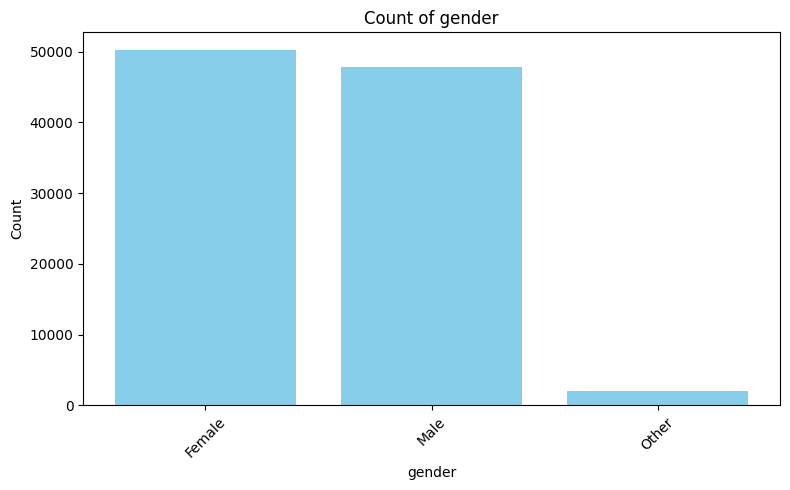

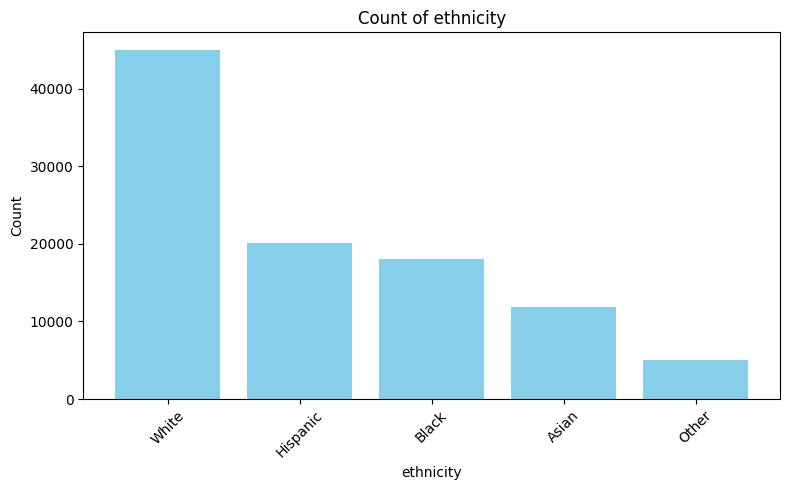

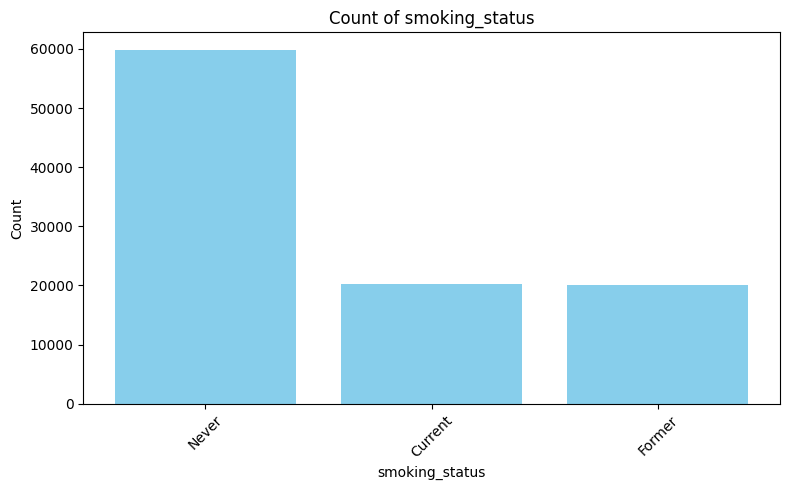

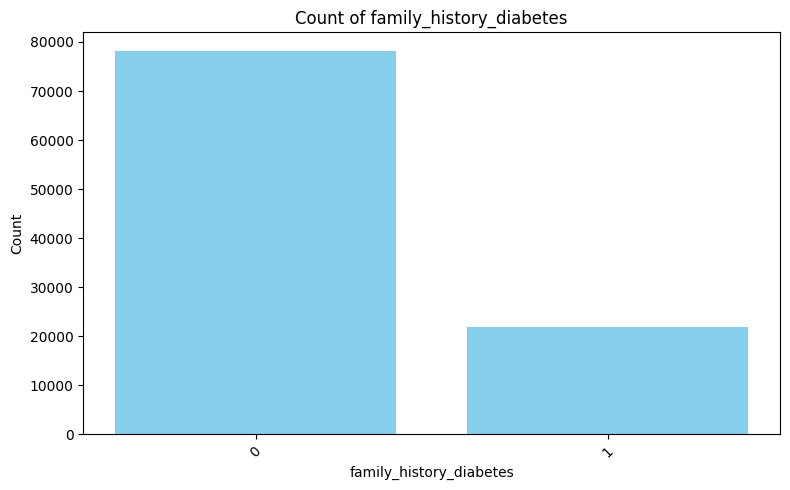

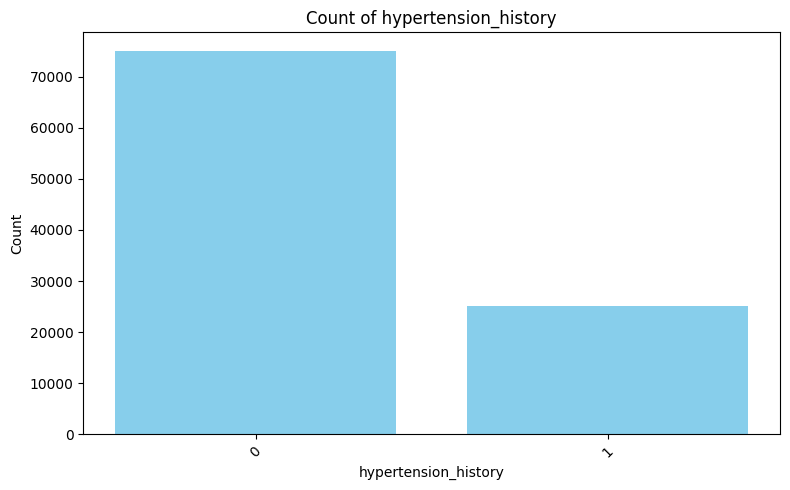

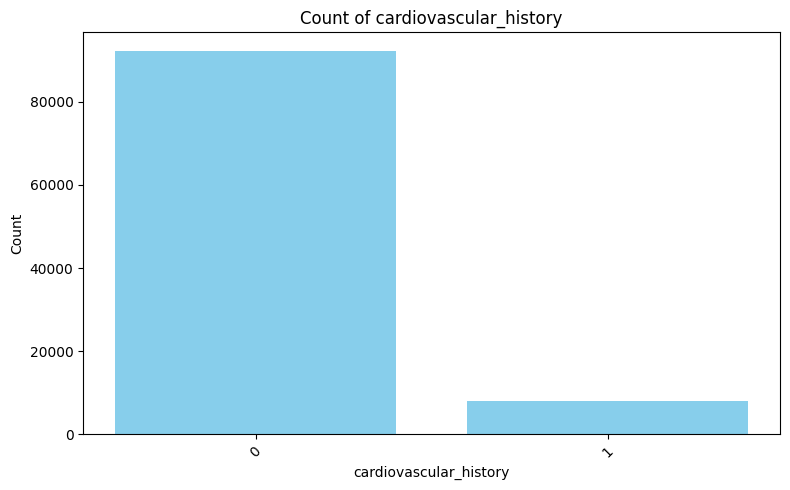

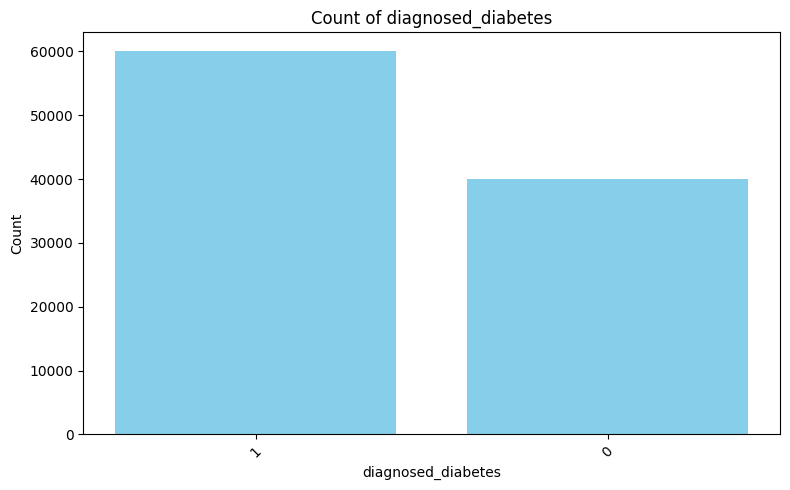

In [6]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

categorical_cols = ["gender", "ethnicity", "smoking_status", "family_history_diabetes",
                    "hypertension_history", "cardiovascular_history", "diagnosed_diabetes"]

for col in categorical_cols:
    counts = diabetes_df.groupBy(col).count().orderBy('count', ascending=False).toPandas()
    
    # Create x positions as range(len(categories))
    x_pos = np.arange(len(counts[col]))
    
    plt.figure(figsize=(8,5))
    plt.bar(x_pos, counts['count'], color='skyblue')
    
    # Set the x-axis tick labels to the category names and rotate
    plt.xticks(x_pos, counts[col], rotation=45)
    
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()


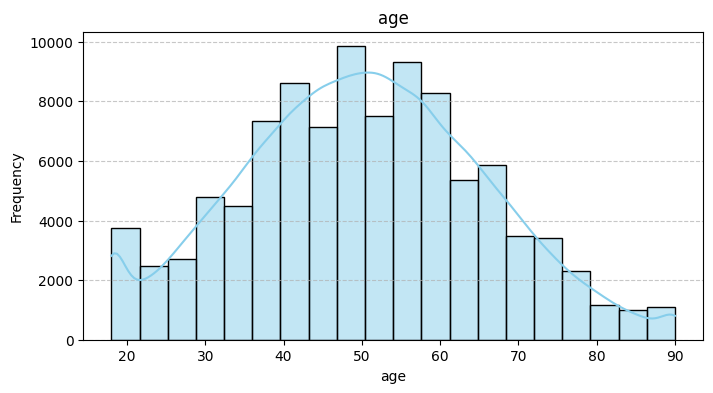

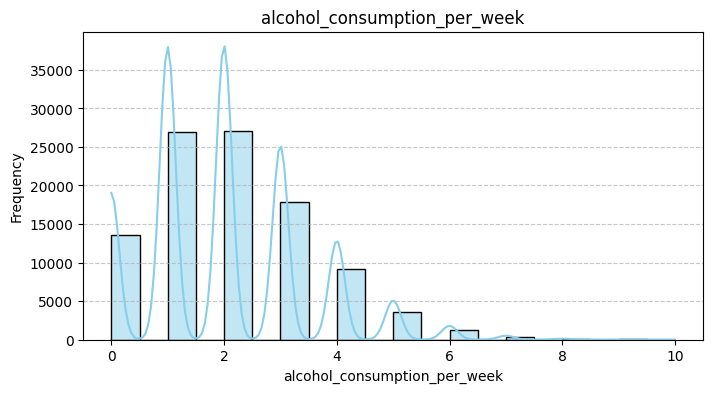

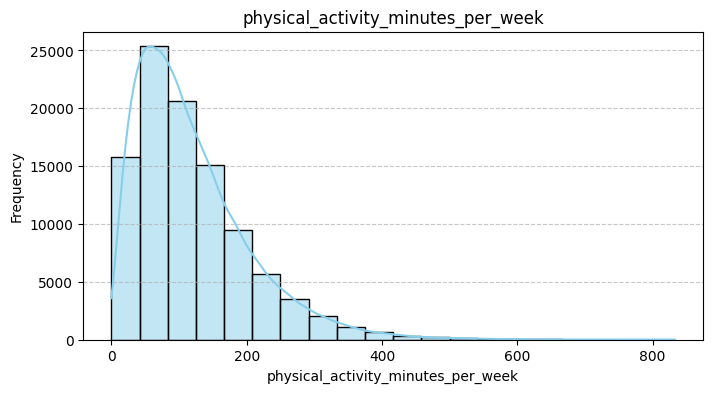

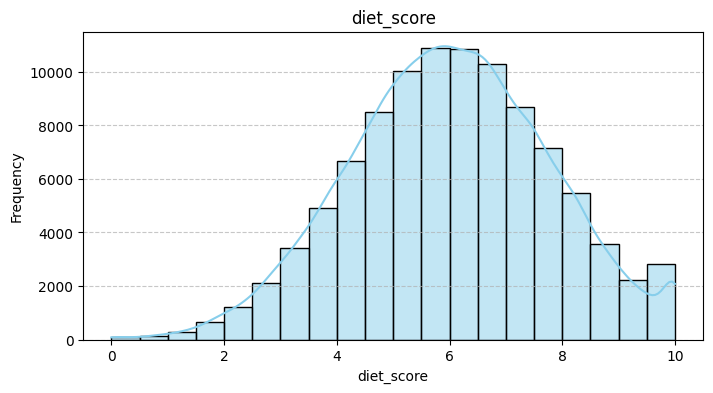

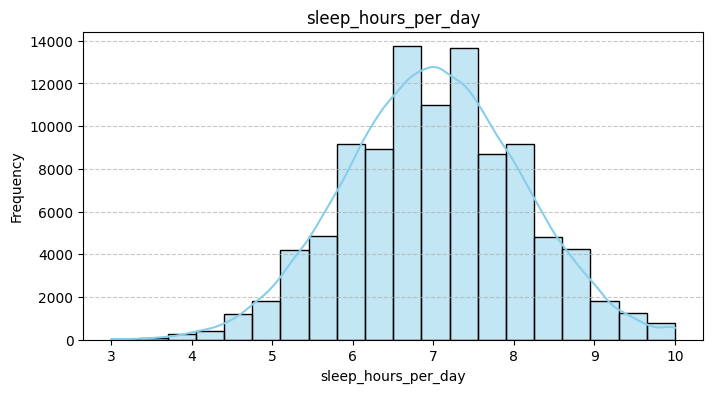

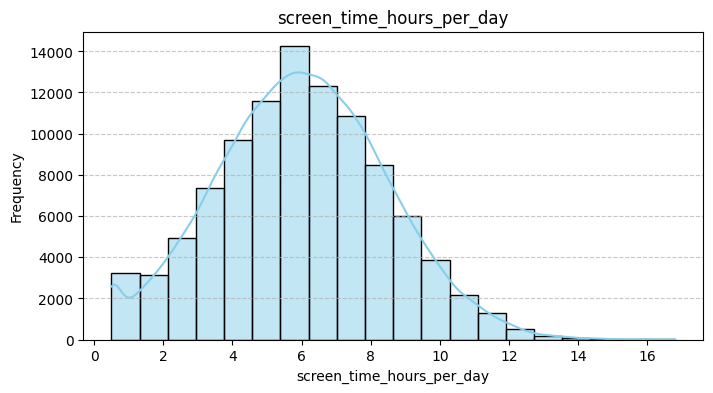

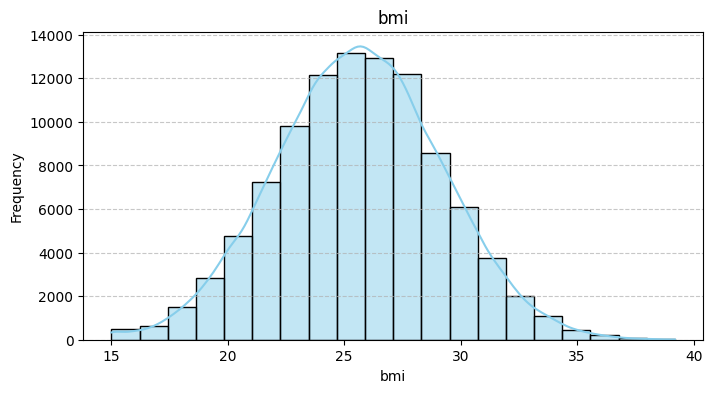

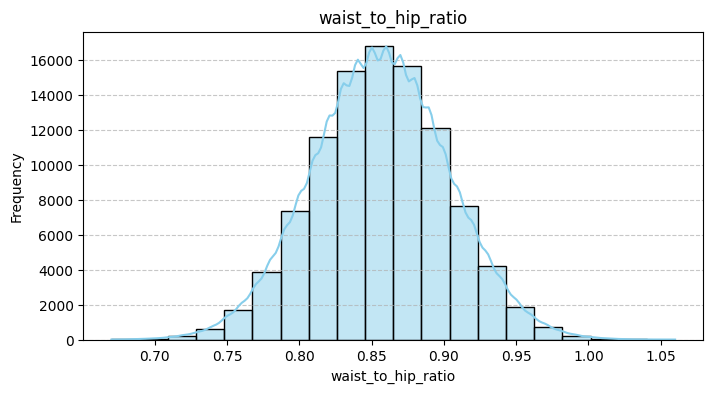

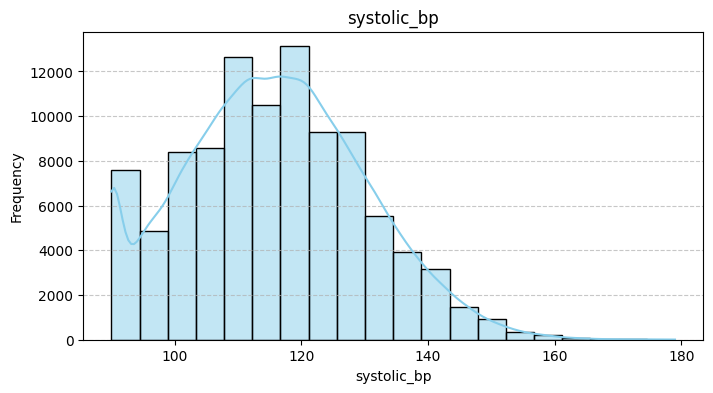

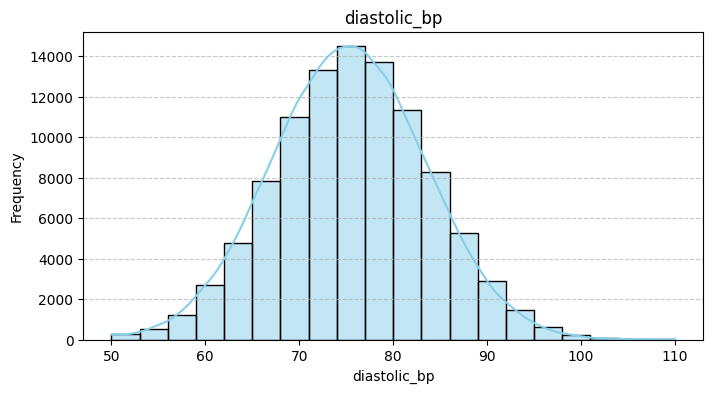

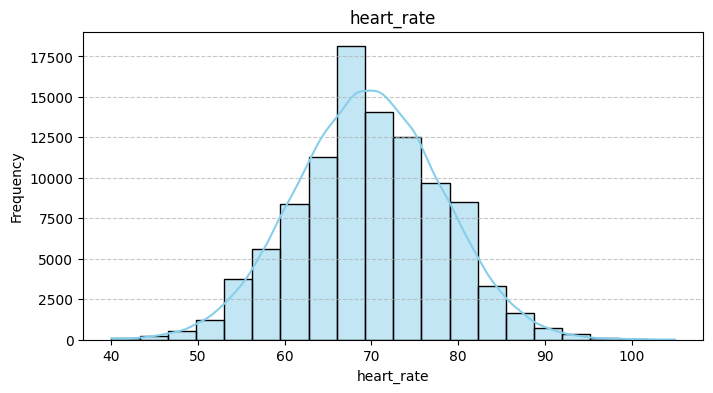

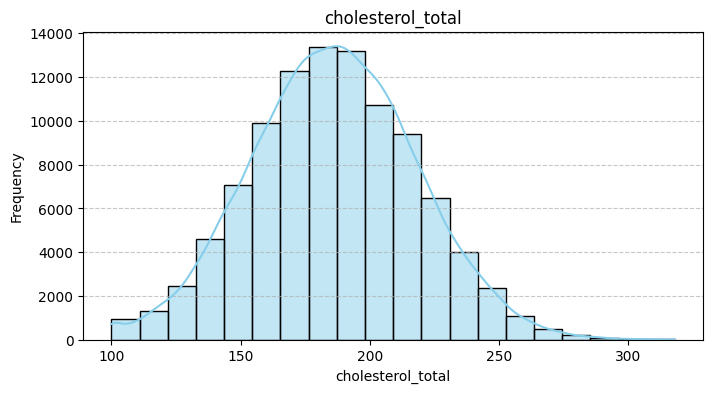

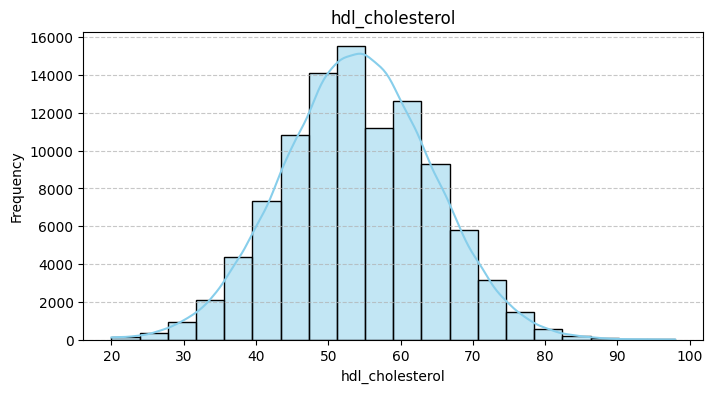

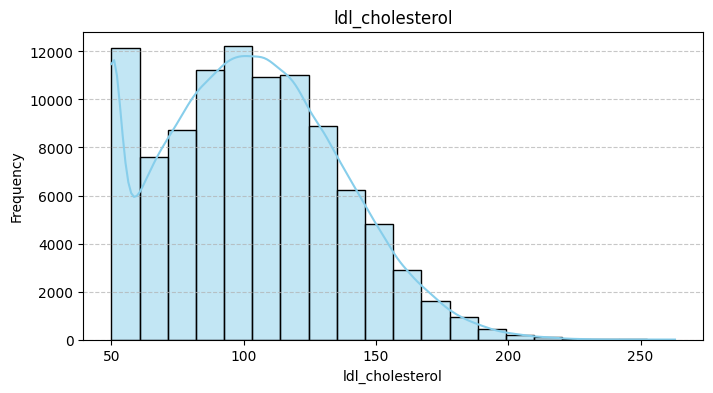

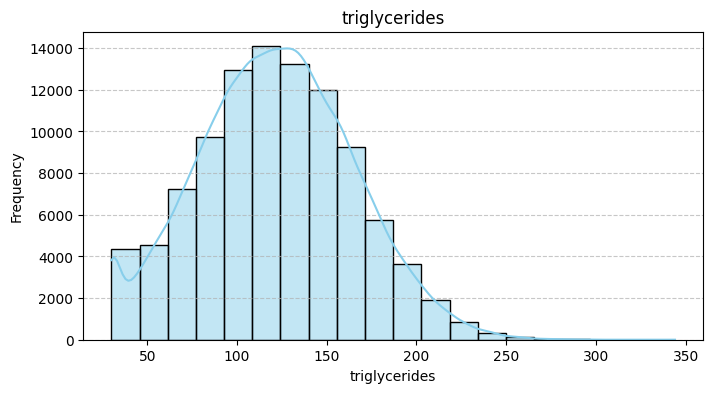

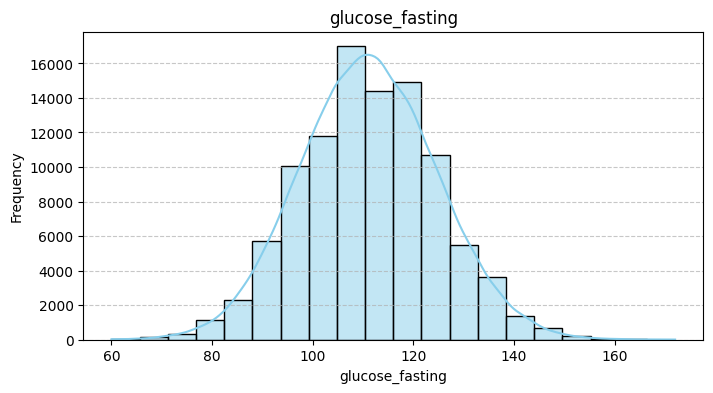

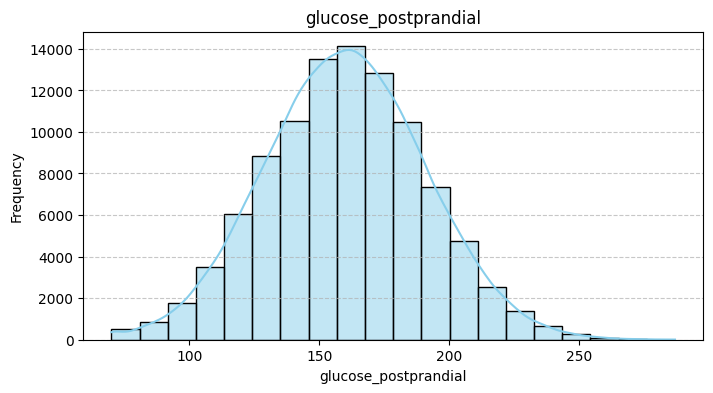

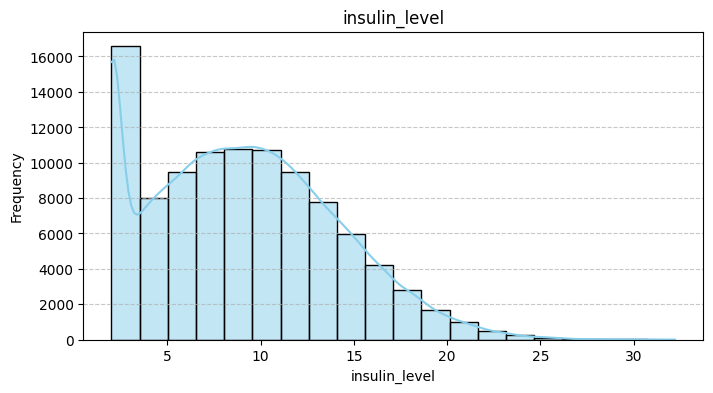

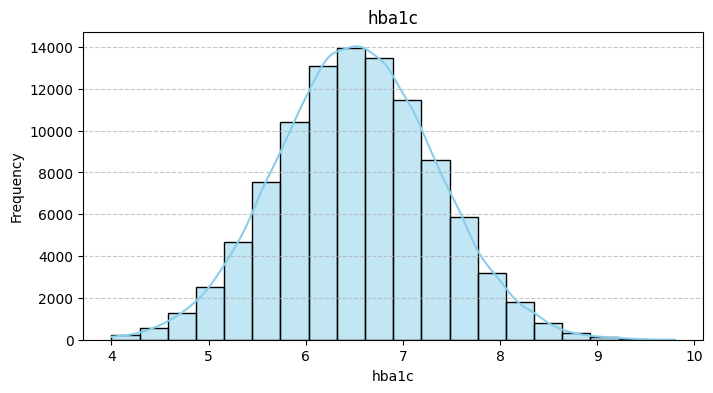

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['age','alcohol_consumption_per_week','physical_activity_minutes_per_week',
        'diet_score','sleep_hours_per_day','screen_time_hours_per_day',
        'bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate',
        'cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides',
        'glucose_fasting','glucose_postprandial','insulin_level','hba1c']

for col in cols:
    data = diabetes_df.select(col).toPandas()[col]
    
    plt.figure(figsize=(8,4))
    sns.histplot(data, bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
#Convertir a categoricas a numericas 
from pyspark.ml.feature import StringIndexer

categorical_cols = ["gender", "ethnicity", "smoking_status"]

for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_num")
    diabetes_df = indexer.fit(diabetes_df).transform(diabetes_df)


In [13]:

cols_num=["gender_num", "ethnicity_num", "smoking_status_num",'alcohol_consumption_per_week','physical_activity_minutes_per_week','diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes','hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c', 'diagnosed_diabetes']

diabetes_df[cols_num].show()

+----------+-------------+------------------+----------------------------+----------------------------------+----------+-------------------+-------------------------+-----------------------+--------------------+----------------------+----+------------------+-----------+------------+----------+-----------------+---------------+---------------+-------------+---------------+--------------------+-------------+-----+------------------+
|gender_num|ethnicity_num|smoking_status_num|alcohol_consumption_per_week|physical_activity_minutes_per_week|diet_score|sleep_hours_per_day|screen_time_hours_per_day|family_history_diabetes|hypertension_history|cardiovascular_history| bmi|waist_to_hip_ratio|systolic_bp|diastolic_bp|heart_rate|cholesterol_total|hdl_cholesterol|ldl_cholesterol|triglycerides|glucose_fasting|glucose_postprandial|insulin_level|hba1c|diagnosed_diabetes|
+----------+-------------+------------------+----------------------------+----------------------------------+----------+----------

In [14]:
cols_num=["age","gender_num", "ethnicity_num", "smoking_status_num",'alcohol_consumption_per_week','physical_activity_minutes_per_week','diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes','hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c', 'diagnosed_diabetes']

desc_df = diabetes_df.describe(cols_num)
desc_data = desc_df.collect()

# List of stats
stats = [row['summary'] for row in desc_data]

# Loop through each column and print stats nicely
for col in cols_num:
    print(f"\n{'-'*40}")
    print(f"Descriptive stats for: {col}")
    print(f"{'-'*40}")
    for row in desc_data:
        stat_name = row['summary']
        val = row[col]
        try:
            # Try formatting as float with 2 decimals
            val = float(val)
            val = f"{val:,.2f}"
        except:
            # Leave as string if conversion fails (e.g., count)
            pass
        print(f"{stat_name:<10}: {val}")



----------------------------------------
Descriptive stats for: age
----------------------------------------
count     : 100,000.00
mean      : 50.12
stddev    : 15.60
min       : 18.00
max       : 90.00

----------------------------------------
Descriptive stats for: gender_num
----------------------------------------
count     : 100,000.00
mean      : 0.52
stddev    : 0.54
min       : 0.00
max       : 2.00

----------------------------------------
Descriptive stats for: ethnicity_num
----------------------------------------
count     : 100,000.00
mean      : 1.12
stddev    : 1.24
min       : 0.00
max       : 4.00

----------------------------------------
Descriptive stats for: smoking_status_num
----------------------------------------
count     : 100,000.00
mean      : 0.60
stddev    : 0.80
min       : 0.00
max       : 2.00

----------------------------------------
Descriptive stats for: alcohol_consumption_per_week
----------------------------------------
count     : 100,000.00
me

In [15]:
diabetes_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- income_level: string (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- alcohol_consumption_per_week: integer (nullable = true)
 |-- physical_activity_minutes_per_week: integer (nullable = true)
 |-- diet_score: double (nullable = true)
 |-- sleep_hours_per_day: double (nullable = true)
 |-- screen_time_hours_per_day: double (nullable = true)
 |-- family_history_diabetes: integer (nullable = true)
 |-- hypertension_history: integer (nullable = true)
 |-- cardiovascular_history: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- waist_to_hip_ratio: double (nullable = true)
 |-- systolic_bp: integer (nullable = true)
 |-- diastolic_bp: integer (nullable = true)
 |-- heart_rate: integer (nullable = true)
 |-- cholesterol_total: integer (nu

In [ ]:
# Almacenar el conjunto de datos limpio en la base de datos
diabetes_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "diabetes") \
    .save()

# Inspección de datos
Previo a entrenar el modelo es común que se realice algún tipo de descripción de los datos, para tener una idea del tipo de problema con el que nos enfrentamos. A continuación, algunas operacions útiles que podemos usar.


In [ ]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "diabetes") \
    .load()

df.show()

In [16]:
# Seleccionar variables para experimento

cols_num= ["age","gender_num", "ethnicity_num", "smoking_status_num",'alcohol_consumption_per_week','physical_activity_minutes_per_week','diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes','hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c', 'diagnosed_diabetes']
df = df[cols_num]

NameError: name 'df' is not defined

In [ ]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

input_cols =["age","gender_num", "ethnicity_num", "smoking_status_num",'alcohol_consumption_per_week','physical_activity_minutes_per_week','diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes','hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp','diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol','triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c']

assembler = VectorAssembler(
    inputCols=input_cols,
    outputCol='features')

vector_df = assembler.transform(df)
vector_df = vector_df.select(['features', 'diagnosed_diabetes'])
vector_df.show()


In [ ]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Estandarización
Como recordamos de los módulos anteriores es deseable que los datos se encuentren estandarizados o normalizados, para evitar que la magnitud de ciertos atributos dominen el proceso de entrenamiento. El módulo `pyspark.ml.feature` tiene varias alternativas. A continuación se presenta una.

In [ ]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df.show()

# Regresión lineal
Como ejemplo de un tipo de modelo a entrenar usaremos una regresión lineal básica para tratar de predecir el precio. Para ellos utilizaremos los datos estandarizados.

In [ ]:
# Nótese que no se hace partición de datos de entrenamiento (ejercicio posterior).
from pyspark.ml.regression import LinearRegression

regression = LinearRegression(featuresCol='scaled', labelCol='price')
regression_model = regression.fit(scaled_df)

print('Pesos: {}\n b: {}'.format(regression_model.coefficients, regression_model.intercept))

print('RMSE: {} r2: {}'.format(
    regression_model.summary.rootMeanSquaredError,
    regression_model.summary.r2))

scaled_df.describe().show()

# Si se quiere hacer predicciones nada más se requiere llamar a regression_model.transform(df)
# Esto regresa el dataset con una columna nueva

# Ejercicio
- Dividir los datos leídos desde la base de datos en dos conjuntos utilizando las funcionalidades de muestreo de Spark.
- Entrene el modelo en uno y evalúe en otro. Escriba los resultados evaluados en una tabla en Postgresql.
- Implementar un esquema de k-fold cross validation. Evalúe los resultados según RMSE y r2.
- Pruebe diferentes parámetros a la regresión.
- Pruebe diferentes tipos de regresión.